In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ap = pd.read_csv('./data/AirPassengers.csv')

In [3]:
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# Month 컬럼 삭제
ap.drop(columns=['Month'], inplace=True, errors='ignore')

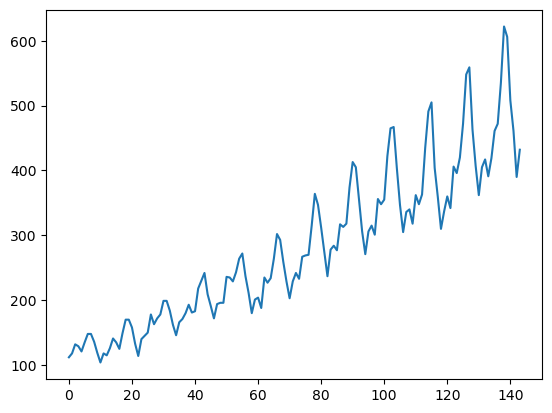

In [5]:
plt.plot(ap)
plt.show()

In [6]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

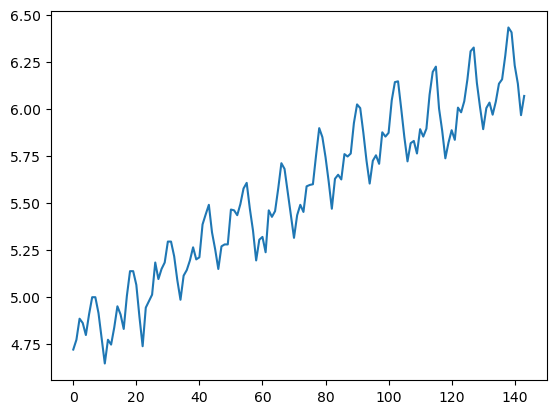

In [7]:
plt.plot(log_transformed)
plt.show()

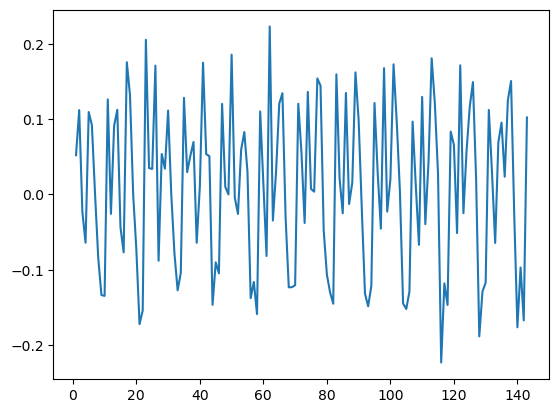

In [8]:
# 차분
diffed = log_transformed.diff()

plt.plot(diffed)
plt.show()

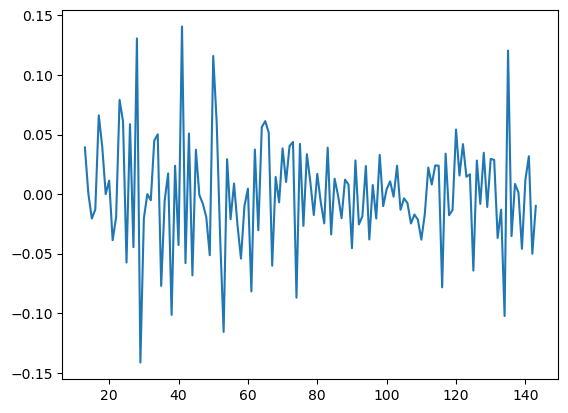

In [9]:
# 주기를 12로 하는 계절 차분
seasonally_diffed = diffed.diff(12)
# 차분 후 null 값 제거 (첫 12줄)
seasonally_diffed.dropna(inplace = True)

plt.plot(seasonally_diffed)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # ADF검정 함수
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('### ADF statistics ###', stat, sep='\n')
    print('\n### P-value ###', p_value, sep='\n')

In [11]:
adf_test(seasonally_diffed)

### ADF statistics ###
-4.443324941831131

### P-value ###
0.00024859123113839645


# 시계열 분류

In [12]:
# 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [13]:
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [14]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [15]:
y.sum()

np.int64(21)

In [16]:
len(y) - y.sum()

np.int64(67)

In [17]:
# 데이터셋 가공
def custom_classification_split(x, y, test_size=0.3): # 수업 때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size) # 21 * 0.3 (test_size)
    num_false = int((len(y)-y.sum())*test_size) ## (88 - 21)*0.3 (test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list() # y==False 샘플중 첫 num_false 만큼 , y==True 샘플중 첫 num_true 만큼
    
    y_train = y.drop(id_list) # 0.3만큼의 test 샘플들을 제외한 나머지
    y_test = y[id_list]
    X_train = x[~x['id'].isin(id_list)] # id가 id_list에 있는 경우가 아닌 샘플 0.7은 train으로
    X_test = x[x['id'].isin(id_list)] # id가 id_list에 있는 경우가 아닌 샘플 0.3은 train으로
    
    return X_train, y_train, X_test, y_test

In [18]:
# Scikit-learn tran_test_split() 활용 데이터셋 가공
def sensor_level_split(X, y, test_size=0.3, random_state=42):
    from sklearn.model_selection import train_test_split
    
    """
    X: 전체 데이터 (센서별 시간대 row)
    y: 센서별 label (index = sensor id)
    test_size: test 비율
    """
    # 센서 아이디 추출 (1~88)
    sensor_ids = y.index.to_list() 
    
    # 센서 아이디를 랜덤으로 7:3으로 나누기()
    test_size=0.3
    y_train_ids, y_test_ids = train_test_split(
            sensor_ids,
            test_size=test_size,
            stratify=y,  # True, False 각각 (1 - test_size):(test_size)로 분할
            random_state=random_state
    )

    # 위 분할된 y의 'id' 기준으로 X row 선택
    X_train = X[X['id'].isin(y_train_ids)]
    X_test  = X[X['id'].isin(y_test_ids)]
    y_train = y.loc[y_train_ids]
    y_test  = y.loc[y_test_ids]

    return X_train, X_test, y_train, y_test

In [19]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [20]:
# X_train, y_train, X_test, y_test = sensor_level_split(timeseries, y, test_size=0.25)

In [21]:
print(len(X_train)/15, len(X_test)/15)

67.0 21.0


In [22]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [23]:
# Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id='id',
                                    column_sort='time',
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████| 37/37 [00:03<00:00, 11.14it/s]


In [24]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id='id',
                                    column_sort='time',
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████| 32/32 [00:01<00:00, 16.45it/s]


In [25]:
# impute
impute(comprehensive_features_train)

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.022809,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,1.907284,2.098274,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.308605,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [26]:
impute(comprehensive_features_test)

C:\Users\user\miniconda3\envs\myenv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.163956,2.197225,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


In [27]:
# RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

# RandomForest 모델 학습
rf_clf.fit(comprehensive_features_train, y_train)

# RandomForest 컬럼 순서 맞추기
comprehensive_features_test = comprehensive_features_test[comprehensive_features_train.columns]

# 모델 스코어
rf_clf.score(comprehensive_features_test, y_test)

0.5714285714285714

In [28]:
# XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델 학습
xgb_clf.fit(comprehensive_features_train, y_train)

# XGBoost 모델 스코어
xgb_clf.score(comprehensive_features_test, y_test)

0.5238095238095238

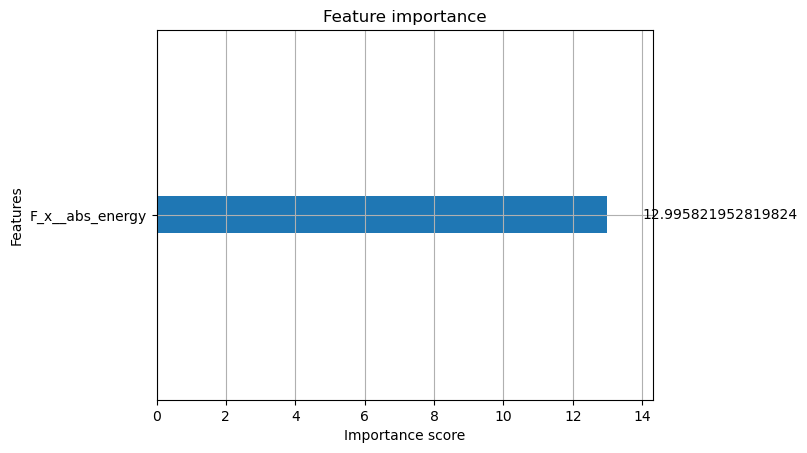

In [29]:
# XGBoost plot_importance 확인 및 시각화
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [30]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

np.int64(1)

In [31]:
# Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 0.6875,
  'recall': 0.6875,
  'f1-score': 0.6875,
  'support': 16.0},
 'false': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0},
 'accuracy': 0.5238095238095238,
 'macro avg': {'precision': 0.34375,
  'recall': 0.34375,
  'f1-score': 0.34375,
  'support': 21.0},
 'weighted avg': {'precision': 0.5238095238095238,
  'recall': 0.5238095238095238,
  'f1-score': 0.5238095238095238,
  'support': 21.0}}